ver 1.0

# 분석 환경 준비

In [1]:
# 오디오 전처리를 위한 라이브러리
import librosa 
import librosa.display as dsp
from IPython.display import Audio
import matplotlib.pyplot as plt

# 데이터 전처리를 위한 라이브러리
import pandas as pd
import numpy as np
from tqdm import tqdm
import os


# GPU 할당
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #GPU 할당

# 구글드라이브 마운트

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## 데이터 가져오기 
* 데이터 로드 후 MFCC를 이용하여 특징 추출
* 데이터 전처리
  * 데이터 길이 맞추기
    * 가장 긴 음성 데이터를 찾아 패딩
  * MFCC 데이터 스케일링 (정규화)

In [3]:
## ex) 한개의 wav 로드 해보기
data, sample_rate = librosa.load('/content/drive/MyDrive/졸업작품/baby_data/bellypain/bellypain_001.wav', sr = 16000)

print('sample_rate:', sample_rate, ', audio shape:', data.shape)
print('length:', data.shape[0]/float(sample_rate), 'secs')

sample_rate: 16000 , audio shape: (109120,)
length: 6.82 secs


In [4]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# 데이터 폴더 경로
data_folder = '/content/drive/MyDrive/졸업작품/baby_data/'

# 클래스(라벨) 목록
class_names = ['bellypain', 'burping', 'discomfort', 'hungry', 'tired']

# 빈 리스트 생성
dataset = []

# 가장 긴 음성 파일의 길이 찾기
max_length = 0

# 각 클래스(라벨) 폴더에서 WAV 파일 불러오기
for class_name in class_names:
    class_folder = os.path.join(data_folder, class_name)
    wav_files = [f for f in os.listdir(class_folder) if f.endswith('.wav')] # .wav 확장자를 가진 파일만 필터링
    for wav_file in tqdm(wav_files, colour='green'):
        wav_path = os.path.join(class_folder, wav_file)
        audio, sr = librosa.load(wav_path, sr=16000)  # 음성 파일 불러오기
        mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)  # MFCC 추출
        dataset.append([mfcc, class_name])  # 데이터셋에 추가
        
        # 가장 긴 음성 파일의 길이 갱신
        if mfcc.shape[1] > max_length:
            max_length = mfcc.shape[1]

# 음성 데이터 패딩
for i in range(len(dataset)):
    data, label = dataset[i]
    padding = max_length - data.shape[1]  # 패딩할 길이 계산
    padded_data = np.pad(data, ((0, 0), (0, padding)), mode='constant')  # 음성 데이터 패딩
    dataset[i][0] = padded_data

# 데이터셋을 NumPy 배열로 변환
dataset = np.array(dataset)

# MFCC 데이터 스케일링 (정규화)
scaler = StandardScaler()
for i in range(len(dataset)):
    dataset[i, 0] = scaler.fit_transform(dataset[i, 0])

# 데이터셋 저장 (선택적)
np.save('dataset.npy', dataset)

# DataFrame으로 변환 (선택적)
cryraw = pd.DataFrame(dataset, columns=['data', 'label'])

# 결과 확인
print("")
print("Total crydata:", len(dataset))
print('Dataset shape:', dataset.shape)


100%|██████████| 24/24 [00:10<00:00,  2.20it/s]
<ipython-input-4-212213836acd>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(dataset)



Total crydata: 467
Dataset shape: (467, 2)


In [5]:
mfcc.shape # (MFCC의 계수 개수, 시간의 프레임 개수)

(40, 212)

In [6]:
dataset.shape

(467, 2)

## MFCC 시각화

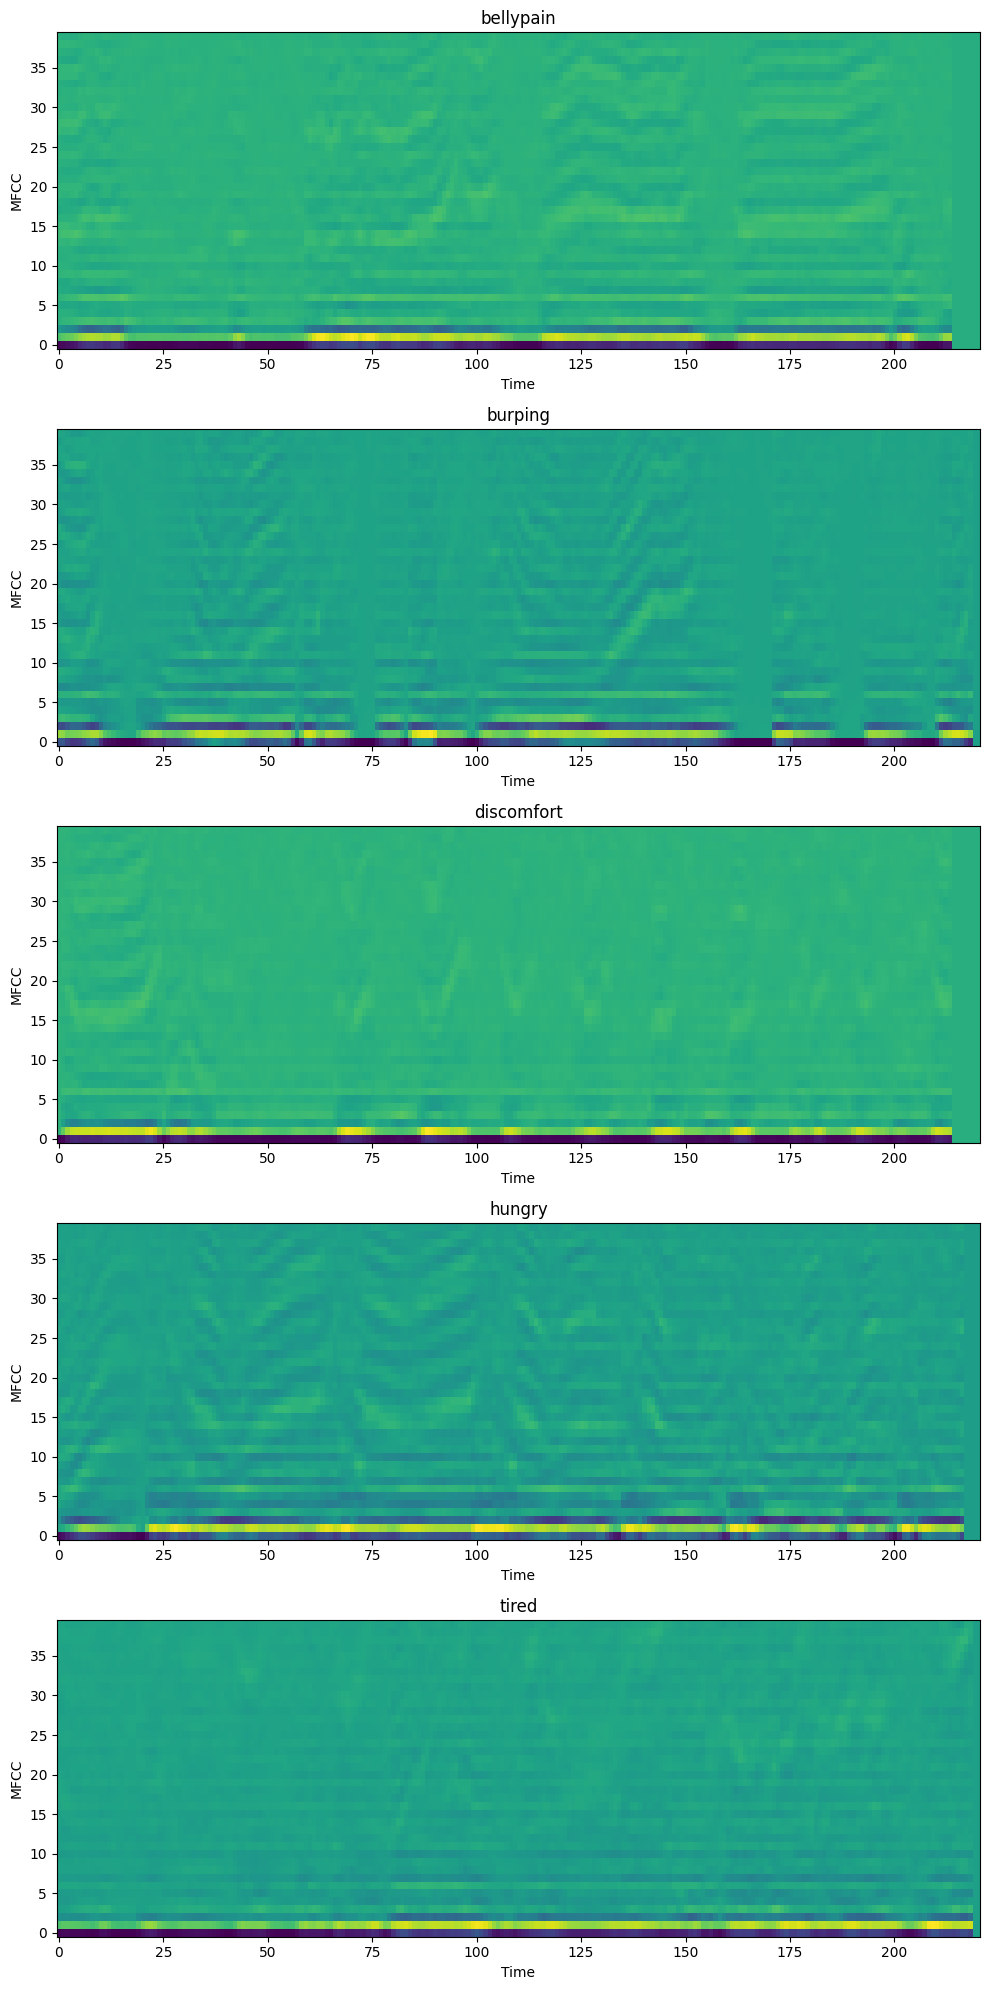

In [7]:
import matplotlib.pyplot as plt

# 클래스별로 첫 번째 샘플의 MFCC 시각화
fig, axes = plt.subplots(nrows=len(class_names), figsize=(10, 20))

for i, class_name in enumerate(class_names):
    # 해당 클래스에 속하는 샘플의 MFCC 데이터 추출
    class_data = cryraw[cryraw['label'] == class_name]['data'].values
    mfcc = class_data[0]  # 첫 번째 샘플의 MFCC

    # MFCC 시각화
    axes[i].imshow(mfcc, aspect='auto', origin='lower', cmap='viridis')
    axes[i].set_title(class_name)  # 그래프 제목에 클래스 이름 설정
    axes[i].set_xlabel('Time')  # x축 레이블 설정
    axes[i].set_ylabel('MFCC')  # y축 레이블 설정

plt.tight_layout()  # 그래프 간격 조정
plt.show()  # 그래프 출력


## 데이터 살펴보기
* 데이터 전처리

In [8]:
cryraw.info()
print(" ")
cryraw['label'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    467 non-null    object
 1   label   467 non-null    object
dtypes: object(2)
memory usage: 7.4+ KB
 


array(['bellypain', 'burping', 'discomfort', 'hungry', 'tired'],
      dtype=object)

* 판다스 데이터프레임을 통해 데이터를 정리하고 정보를 살펴보면 label의 Dtpye이 object인 것을 확인할 수 있다. 

* 문자 형태일 경우, 학습하는데 방해가 될 수 있기 때문에 ***라벨 인코딩***을 하고자 한다.

In [9]:
from sklearn.preprocessing import LabelEncoder

# 라벨 인코더 객체 생성
label_encoder = LabelEncoder()

# 라벨 인코딩 수행
encoded_labels = label_encoder.fit_transform(cryraw['label'])

# 인코딩된 라벨을 새로운 열로 추가
cryraw['encoded_label'] = encoded_labels

# 인코딩된 라벨 확인
unique_labels = np.unique(encoded_labels) # 중복된 값이 제외된 고유한 값 추출(0,1,2,3,4)
print("Encoded Labels:", unique_labels)


Encoded Labels: [0 1 2 3 4]


* 'bellypain'은 0, 'burping'은 1, 'discomfort'은 2, 'hungry'는 3, 'tired'는 4

In [10]:
# 라벨 인코딩 확인 
cryraw

,data,label,encoded_label
0,"[[-6.032199, -5.902637, -5.7865877, -5.6922483...",bellypain,0
1,"[[-4.8408723, -4.551224, -4.679181, -4.706105,...",bellypain,0
2,"[[-6.183488, -6.1178083, -6.040712, -6.001561,...",bellypain,0
3,"[[-6.091229, -6.1258936, -6.2362537, -6.244998...",bellypain,0
4,"[[-5.4842343, -4.751037, -4.2346807, -4.021401...",bellypain,0
...,...,...,...
462,"[[-6.1136937, -6.0992007, -5.913093, -5.780298...",tired,4
463,"[[-5.738158, -5.6414766, -5.1716185, -4.971617...",tired,4
464,"[[-4.237043, -3.8339427, -3.4687376, -3.195824...",tired,4
465,"[[-6.244998, -6.244998, -6.244998, -6.244998, ...",tired,4


## 훈련, 검증, 테스트 셋으로 데이터 나누기

- 이제 cnn 모델에 입력하기 위해서 데이터의 차원을 조정해야함.

- CNN 모델은 입력 데이터의 차원을 (샘플 수, 높이, 너비, 채널) 형태로 기대

In [11]:
import numpy as np

# 데이터셋의 형태 확인
print("Total crydata:", len(dataset))
print("Dataset shape:", dataset.shape)
print("mfcc.shape:", mfcc.shape)

# MFCC 데이터 이미지 형태로 변환 ( 차원 확장 for CNN )
images = np.expand_dims(mfcc, axis=0)
images = np.repeat(images, repeats=467, axis=0)
images = np.expand_dims(images, axis=-1)

# 데이터셋 형태 확인
print("Images shape:", images.shape)

Total crydata: 467
Dataset shape: (467, 2)
mfcc.shape: (40, 221)
Images shape: (467, 40, 221, 1)


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# 데이터셋 분할
X = images
y = dataset[:, 1] # 클래스(라벨) 데이터 추출

# 라벨 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# 분할된 데이터셋 확인
print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)


Train data shape: (298, 40, 221, 1)
Validation data shape: (75, 40, 221, 1)
Test data shape: (94, 40, 221, 1)


In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 데이터셋 분할
X = images
y = dataset[:, 1] # 클래스(라벨) 데이터 추출

# 라벨 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded) # 라벨 데이터를 원-핫 인코딩으로 변환

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, stratify=y_onehot, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# 분할된 데이터셋 확인
print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

print("Train label shape:", y_train.shape)
print("Validation label shape:", y_val.shape)
print("Test label shape:", y_test.shape)

Train data shape: (298, 40, 221, 1)
Validation data shape: (75, 40, 221, 1)
Test data shape: (94, 40, 221, 1)
Train label shape: (298, 5)
Validation label shape: (75, 5)
Test label shape: (94, 5)


* 데이터 분할과 MFCC 데이터의 이미지 형태 변환이 잘 이루어져 있음.
입력 데이터 준비 완료!

## 모델 구조 정의

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

# CNN 모델 정의
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 221, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 정보 출력
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 219, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 109, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 107, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 53, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 51, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 25, 128)       0

In [15]:
# # 원-핫 인코딩
# num_classes = len(label_encoder.classes_)
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_val = keras.utils.to_categorical(y_val, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)


# print(y_train.shape)
# print(y_val.shape)
# print(y_test.shape)


In [16]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
10/10 [==============================] - 8s 536ms/step - loss: 0.9156 - accuracy: 0.7685 - val_loss: 0.6840 - val_accuracy: 0.8400
Epoch 2/10
10/10 [==============================] - 5s 462ms/step - loss: 0.6953 - accuracy: 0.8389 - val_loss: 0.6694 - val_accuracy: 0.8400
Epoch 3/10
10/10 [==============================] - 7s 706ms/step - loss: 0.6602 - accuracy: 0.8389 - val_loss: 0.6811 - val_accuracy: 0.8400
Epoch 4/10
10/10 [==============================] - 5s 459ms/step - loss: 0.6845 - accuracy: 0.8389 - val_loss: 0.6733 - val_accuracy: 0.8400
Epoch 5/10
10/10 [==============================] - 5s 462ms/step - loss: 0.6963 - accuracy: 0.8389 - val_loss: 0.6476 - val_accuracy: 0.8400
Epoch 6/10
10/10 [==============================] - 8s 790ms/step - loss: 0.6589 - accuracy: 0.8389 - val_loss: 0.6499 - val_accuracy: 0.8400
Epoch 7/10
10/10 [==============================] - 5s 463ms/step - loss: 0.6583 - accuracy: 0.8389 - val_loss: 0.6604 - val_accuracy: 0.8400
Epoch 

In [17]:
# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)

# 평가 결과 출력
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


3/3 [==============================] - 0s 116ms/step - loss: 0.6532 - accuracy: 0.8404
Test Loss: 0.6531726121902466
Test Accuracy: 0.8404255509376526


In [18]:
import numpy as np

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 예측 결과를 클래스로 변환
y_pred_classes = np.argmax(y_pred, axis=1)

# 실제 클래스로 변환
y_test_classes = np.argmax(y_test, axis=1)

# 클래스별 정확도 계산
class_accuracy = np.mean(y_pred_classes == y_test_classes)

# 클래스별 예측 결과 출력
print("Class Predictions:")
for class_idx in range(5):
    class_samples = np.where(y_test_classes == class_idx)[0]
    class_accuracy = np.mean(y_pred_classes[class_samples] == y_test_classes[class_samples])
    print(f"Class {class_idx}: Accuracy = {class_accuracy:.2f}")


3/3 [==============================] - 0s 119ms/step
Class Predictions:
Class 0: Accuracy = 0.00
Class 1: Accuracy = 0.00
Class 2: Accuracy = 0.00
Class 3: Accuracy = 1.00
Class 4: Accuracy = 0.00


In [19]:
# 테스트 데이터 예측
y_pred = model.predict(X_test)

# 예측한 정답을 라벨 인덱스 형태로 변환
y_pred_classes = np.argmax(y_pred, axis=1)

# 실제 정답과 예측한 정답 비교 및 출력
for true_label, pred_label in zip(y_test_classes, y_pred_classes):
    print("실제 정답:", true_label)
    print("예측한 정답:", pred_label)
    print("-" * 20)


3/3 [==============================] - 0s 108ms/step
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 2
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 0
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 4
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------------------
실제 정답: 3
예측한 정답: 3
--------